# Assignment 2 - MC906: Approximating images with 50 circles using Genetic Algorithm

## Problem modeling:

### Individual: an image with 50 circles

Each circle (gene) has the following parameters:
* left(float): distance to the left normalized between [0.0, 1.0]
* top(float): distance to the top normalized between [0.0, 1.0]
* radius(float): Circle radius
* color(array-like(h,s,v)): Color to be used on render coded as HSV
* alpha(float): Opacity level bound to [0.0, 1.0]

### Population: several sets with 50 circles each


In [1]:
""" Circle plotting comparison """

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat

FILL_CIRCLE = -1

fig, axs = plt.subplots(ncols=3, figsize=(15,5))

images = np.full(shape=(3, 500,500, 3), dtype=np.uint8, fill_value=255)
images[:, :250, :, :2] = 0
xy = (250, 250)
radius = 200
alpha = 0.5
color = (255, 0, 0)
norm_color = tuple(c/255 if c > 1 else c for c in color)

# Matplotlib.pyplot
image, ax = images[0], axs[0]
ax.add_artist(plt.Circle(xy, radius, facecolor=norm_color, alpha=alpha, antialiased=False))
ax.imshow(image)
ax.set_title('Matplotlib.pyplot')

# Matplotlib.patches
image, ax = images[1], axs[1]
ax.add_patch(pat.Circle(xy, radius, facecolor=norm_color, alpha=alpha, antialiased=False))
ax.imshow(image)
ax.set_title('Matplotlib.patches')

# OpenCV
# https://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html#circle
image, ax = images[2], axs[2]
circle = np.copy(image)
cv2.circle(circle, center=xy, radius=radius, color=color, thickness=FILL_CIRCLE)
cv2.addWeighted(src1=circle, alpha=alpha, src2=image, beta=1-alpha, gamma=0, dst=image)
ax.imshow(image)
ax.set_title('OpenCV')

# fig.savefig('image', dpi=50)
plt.show()

<Figure size 1500x500 with 3 Axes>

## Useful links:

Aproximação por triangulos: https://github.com/DING-PENG/image-approx

## Indivíduos


<IPython.core.display.Javascript object>


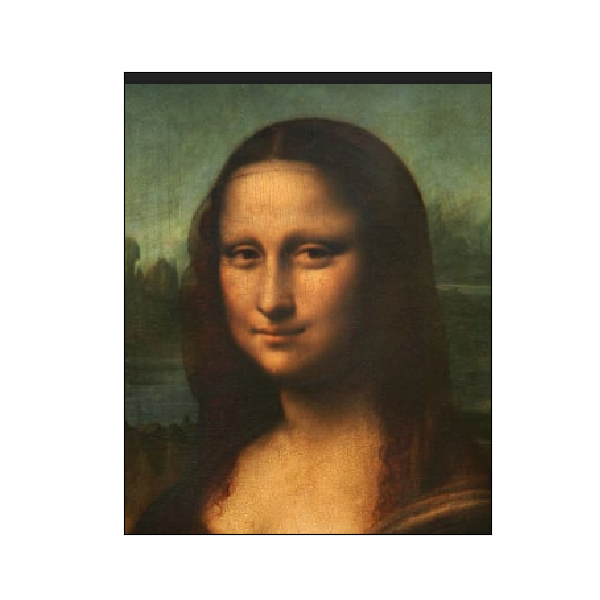

/usr/local/bin/anaconda3/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


<IPython.core.display.Javascript object>


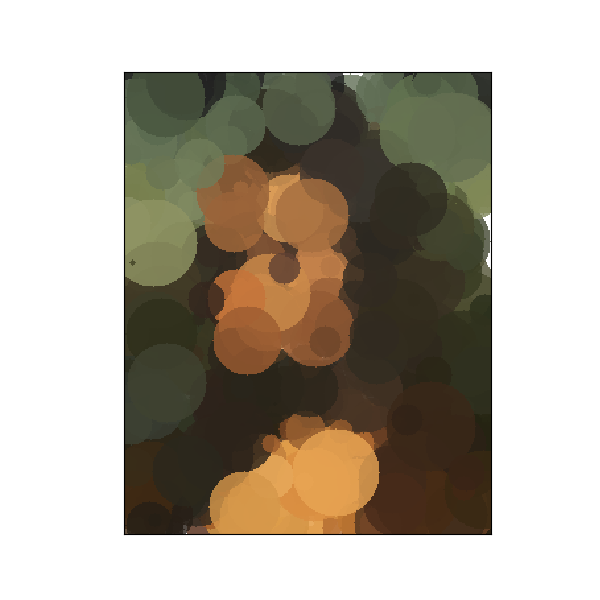

Gen: 0 Fitness: -0.5582791265313326
0
Gen: 1 Size: 700 Best: -0.5606934559537149 Mean: -0.5557170786071486
Enhanced by 0.5606934560
0
Gen: 2 Size: 700 Best: -0.5594200430117345 Mean: -0.5613258712999183
Enhanced by -0.0012734129
0
Gen: 3 Size: 700 Best: -0.5718860154756424 Mean: -0.5617549730573834
Enhanced by 0.0124659725
0
Gen: 4 Size: 700 Best: -0.5629696499591565 Mean: -0.555442649532689
Enhanced by -0.0089163655
0
Gen: 5 Size: 700 Best: -0.5629696499591565 Mean: -0.5555738834402713
Enhanced by -0.0000000000
0
Gen: 6 Size: 700 Best: -0.5622071360944977 Mean: -0.5548555400443985
Enhanced by -0.0007625139
0
Gen: 7 Size: 700 Best: -0.5592226985648553 Mean: -0.5492069304754258
Enhanced by -0.0029844375
0
Gen: 8 Size: 700 Best: -0.5592226985648553 Mean: -0.5510995819911568
Enhanced by -0.0000000000
0
Gen: 9 Size: 700 Best: -0.5592226985648553 Mean: -0.5503340674464925
Enhanced by -0.0000000000
0
Gen: 10 Size: 700 Best: -0.5563788476370509 Mean: -0.5524217778025355
Enhanced by -0.0028438

0
Gen: 85 Size: 700 Best: -0.5793761883284702 Mean: -0.5524662342449819
Enhanced by -0.0000000000
0
Gen: 86 Size: 700 Best: -0.5793761883284702 Mean: -0.5600365186538829
Enhanced by -0.0000000000
0
Gen: 87 Size: 700 Best: -0.5793761883284702 Mean: -0.550395494611638
Enhanced by -0.0000000000
0
Gen: 88 Size: 700 Best: -0.5793761883284702 Mean: -0.5515319105942801
Enhanced by -0.0000000000
0
Gen: 89 Size: 700 Best: -0.5793761883284702 Mean: -0.5548022367923984
Enhanced by -0.0000000000
0
Gen: 90 Size: 700 Best: -0.5793761883284702 Mean: -0.551573561471965
Enhanced by -0.0000000000
0
Gen: 91 Size: 700 Best: -0.5793761883284702 Mean: -0.5542551187046009
Enhanced by -0.0000000000
0
Gen: 92 Size: 700 Best: -0.5793761883284702 Mean: -0.5543621161699175
Enhanced by -0.0000000000
0
Gen: 93 Size: 700 Best: -0.5793761883284702 Mean: -0.5540887309523196
Enhanced by -0.0000000000
0
Gen: 94 Size: 700 Best: -0.5793761883284702 Mean: -0.5533093176680575
Enhanced by -0.0000000000
0
Gen: 95 Size: 700 Be

In [ ]:
%matplotlib notebook
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from time import time

from circle import Circle
from image_from_circles import ImageFromCircles
from individual import Individual
from evolve import Evolve
from utils import rms, plot_image, save_image

from skimage.measure import compare_ssim
from IPython import display

# Read reference image
image = cv2.imread('monalisa.png')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)  # Convert color loaded by OpenCV
# image = image[200:300, 200:300]
plot_image(image)

# circle = Circle()
# image = np.full((50,50, 3), fill_value=255, dtype=np.uint8)
# circle.render(image)

plt.ion()

number_generations = 1000
max_ind_size = 700
pop_size = 10
mr = 0.3
cr = 0.9
ur = 0

def norm_byte_diff(a, b):
    h = a.shape[0]
    w = a.shape[1]
    d = 1
    if len(a.shape) == 3:
        d = a.shape[2]
    # normalized difference
    return sum(abs((a-b).flatten()))/(255*h*w*d)-1

def compare_hsv(a, b):
    def split_hsv(img):
        img_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        h = img_hsv[:,:, 0]
        s = img_hsv[:,:, 1]
        v = img_hsv[:,:, 2]
        return h, s, v
    a_hsv = split_hsv(a)
    b_hsv = split_hsv(b)
    return -compare_ssim(a_hsv[2], b_hsv[2]) * 0.8 + \
        0.15 * norm_byte_diff(a_hsv[0], b_hsv[0]) + \
        0.05 * norm_byte_diff(a_hsv[1], b_hsv[1])

fitness_function=compare_hsv
# fitness_function=lambda a, b: sum((a-b).flatten()**2)**(1/2)

generation = Evolve(image, pop_size=pop_size, crossover_rate=cr, mutation_rate=mr, 
                    max_ind_size=max_ind_size, unmutable_ratio=ur,fitness_function=fitness_function)
generation.evaluate()
fig, ax = generation.plot_image()
print('Gen:', generation.generation, 'Fitness:', generation.solution.fitness)
last_best = 0
for i in range(1, number_generations):

    parents, children = generation.crossover()
    generation.mutate()
    generation.evaluate()
    print('Gen:', i, 'Size:', generation.solution.individual_size,'Best:', generation.solution.fitness, 'Mean:', np.mean([ind.fitness for ind in generation.pop]), end='\r')
#     print(str(generation))
#     if i % 10 == 9:
    if ax:
        ax.clear()
    fig, ax = generation.plot_image((fig, ax) if ax else None)
    print('Gen:', i, 'Size:', generation.solution.individual_size, 'Best:', generation.solution.fitness, 'Mean:', np.mean([ind.fitness for ind in generation.pop]))
    enh = -(generation.solution.fitness - last_best)
    last_best = generation.solution.fitness
    print('Enhanced by {:.10f}'.format(enh))
#         if abs(enh) < 0.000000001:
            # Increase size if hasn't enhanced
#             generation = Evolve(image, pop_size=pop_size, crossover_rate=cr, mutation_rate=mr, 
#                                 individual_size=individual_size, unmutable_ratio=ur, 
#                                 initial_pop=generation.pop, fitness_function=fitness_function)
#             individual_size += 1
#             print('Added a gene, current count =', individual_size)

In [ ]:
norm_byte_diff(np.zeros((10,20, 3)), np.full((10,20,3), fill_value=255))